In [1]:
from osgeo import gdal
from datetime import date, datetime as dt
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

## Read Planet Data

In [2]:
planet_fn_red = "/data/001_planet_sentinel_study/planet/utm11n_sur_ref/images/red/planet_red.vrt"
planet_red = gdal.Open(planet_fn_red)
planet_fns = planet_red.GetFileList()[1:]
planet_dates = [dt.strptime((f.split("/"))[-1][0:15], "%Y%m%d_%H%M%S") for f in planet_fns]
p_red = planet_red.ReadAsArray()
print p_red.shape

planet_fn_nir = "/data/001_planet_sentinel_study/planet/utm11n_sur_ref/images/nir/planet_nir.vrt"
planet_nir = gdal.Open(planet_fn_nir)
p_nir = planet_nir.ReadAsArray()
print p_nir.shape

(182, 3424, 3421)
(182, 3424, 3421)


## Read Sentinel Data

In [3]:
sentinel_fn_red = "/data/001_planet_sentinel_study/sentinel/11SKA_REF/sentinel_red.vrt"
sentinel_red = gdal.Open(sentinel_fn_red)
s_red = sentinel_red.ReadAsArray()
print s_red.shape

sentinel_fns = sentinel_red.GetFileList()[1:]
sentinel_dates = [dt.strptime((f.split("/"))[-1][5:20], "%Y%m%d_%H%M%S") for f in sentinel_fns]

sentinel_fn_nir = "/data/001_planet_sentinel_study/sentinel/11SKA_REF/sentinel_nir.vrt"
sentinel_nir = gdal.Open(sentinel_fn_nir)
s_nir = sentinel_nir.ReadAsArray()
print s_nir.shape

# Get lat/lon information
transf = sentinel_red.GetGeoTransform()
reslon = transf[1]
reslat = transf[5]
cols = sentinel_red.RasterXSize
rows = sentinel_red.RasterYSize
LHS = transf[0]
THS = transf[3]
BHS = THS + (rows * reslat)
RHS = LHS + (cols * reslon)

latgrid = np.arange(THS, BHS, reslat)
longrid = np.arange(LHS, RHS, reslon)

(12, 3424, 3421)
(12, 3424, 3421)


## Extract Values from NDVI stack

In [125]:
pixel_lat = 4061930
pixel_lon = 235799

# Wet/Dry field
# pixel_lat = 4062600
# pixel_lon = 242386

# Good field
# pixel_lat = 4059460
# pixel_lon = 235438

# pixel_lat = 4056980
# pixel_lon = 240191

# pixel_lat = 4063520
# pixel_lon = 235633

win = 5

# ===== GET ROW/COLS FOR PIXEL LAT/LON ===== #

tpix_x = abs(longrid - pixel_lon).argmin()
tpix_y = abs(latgrid - pixel_lat).argmin()

print tpix_x, tpix_y

# ===== EXTRACT SENTINEL VALUES ===== #

sentinel_r = []
sentinel_n = []
sentinel_r_std = []
sentinel_n_std = []

for i in range(0, (s_red.shape)[0]):
        
    sentinel_r.append(np.nanmean(s_red[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1]))
    sentinel_n.append(np.nanmean(s_nir[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1]))
    vals = s_nir[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1].flatten()
    sentinel_r_std.append(np.std(vals))
    vals = s_red[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1].flatten()
    sentinel_n_std.append(np.std(vals))
    
sentinel_df = pd.DataFrame(index = sentinel_dates)
sentinel_df['red'] = [x/10000 for x in sentinel_r]
sentinel_df['nir'] = [x/10000 for x in sentinel_n]
sentinel_df['r_std'] = [x/10000 for x in sentinel_r_std]
sentinel_df['n_std'] = [x/10000 for x in sentinel_n_std]



# ===== EXTRACT PLANET VALUES ===== #

planet_r = []
planet_n = []
planet_r_std = []
planet_n_std = []

for i in range(0, (p_nir.shape)[0]):
        
    planet_r.append(np.nanmean(p_red[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1]))
    planet_n.append(np.nanmean(p_nir[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1]))
    vals = p_nir[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1].flatten()
    planet_n_std.append(np.std(vals))
    vals = p_red[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1].flatten()
    planet_r_std.append(np.std(vals))

planet_df = pd.DataFrame(index = planet_dates)
planet_df['red'] = [x/10000 for x in planet_r]
planet_df['nir'] = [x/10000 for x in planet_n]
planet_df['r_std'] = [x/10000 for x in planet_r_std]
planet_df['n_std'] = [x/10000 for x in planet_n_std]

# Get rid of NaN values present in a row
# planet_df = planet_df[np.isfinite(planet_df['ndvi'])]
planet_df = planet_df.drop(planet_df[(planet_df.red < 0.05)].index)

print "Done."

839 747
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
Done.


## Extract Values from MODIS csv file

In [122]:
# ===== MCD43 OPENING... ===== #

mcd43 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MCD43/bdrf-" + str(pixel_lon) + "-" + str(pixel_lat) + "/BDRF-" + str(pixel_lon) + "-" + str(pixel_lat) + "-MCD43A1-006-results.csv", index_col=2)

mcd43_df = pd.DataFrame(index = mcd43.index)
mcd43_df['nir_iso'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_0']
mcd43_df['nir_vol'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_1']
mcd43_df['nir_geo'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_2']

mcd43_df['red_iso'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_0']
mcd43_df['red_vol'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_1']
mcd43_df['red_geo'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_2']

import xmltodict
import sys
import glob

sys.path.append('/home/tday/BEIS-LC/MODIS')

from Kernels import Kernels

def correction(fiso, fvol, fgeo, giso, gvol, ggeo):
    
    result = (fiso * giso) + (fvol * gvol) + (fgeo * ggeo)
    return result

# ===== Extract illumin conditions from planet xml ===== #

check_date = date(2017, 3, 1)

xmlfiles = sorted(glob.glob("/data/001_planet_sentinel_study/planet/utm11n_sur_ref/xml/*.xml"))

xdates = []
VAA = []
VZA = []
SZA = []
SAA = []
RO = []
LI = []

for xml in xmlfiles:
    
    xmldate = dt.strptime((xml.split("/"))[-1][0:8], "%Y%m%d").date()

    if xmldate == check_date:
        pass
        
    else:

        xdates.append(xmldate)
        
        with open(xml) as fd:
        
            doc = xmltodict.parse(fd.read())
            acq = doc['ps:EarthObservation']['gml:using']['eop:EarthObservationEquipment']['eop:acquisitionParameters']['ps:Acquisition']

            sazimuth = float(acq['opt:illuminationAzimuthAngle']['#text'])
            SAA.append(sazimuth)

            szenith = float(acq['opt:illuminationElevationAngle']['#text'])
            SZA.append(szenith)

            vazimuth = float(acq['ps:azimuthAngle']['#text'])
            VAA.append(vazimuth)

            vzenith = float(acq['ps:spaceCraftViewAngle']['#text'])
            VZA.append(vzenith)

            check_date = xmldate
            

            RAA = sazimuth - vazimuth

            kk = Kernels(vzenith, szenith, RAA, \
                 RossHS = False, RecipFlag = True, MODISSPARSE = True, \
                 normalise = 1, doIntegrals = False, LiType = 'Sparse', RossType = 'Thick' )

            RO.append(kk.Ross[0])
            LI.append(kk.Li[0])

bdrf_df = pd.DataFrame(index = xdates)  
bdrf_df['ROSS'] = RO
bdrf_df['LI'] = LI

CORR = pd.merge(bdrf_df, mcd43_df, left_index=True, right_index=True)

CORR['FINAL_nir'] = correction(CORR['nir_iso'], CORR['nir_vol'], CORR['nir_geo'], 1, CORR['ROSS'], CORR['LI'])
CORR['FINAL_red'] = correction(CORR['red_iso'], CORR['red_vol'], CORR['red_geo'], 1, CORR['ROSS'], CORR['LI'])


# Plot

<IPython.core.display.Javascript object>


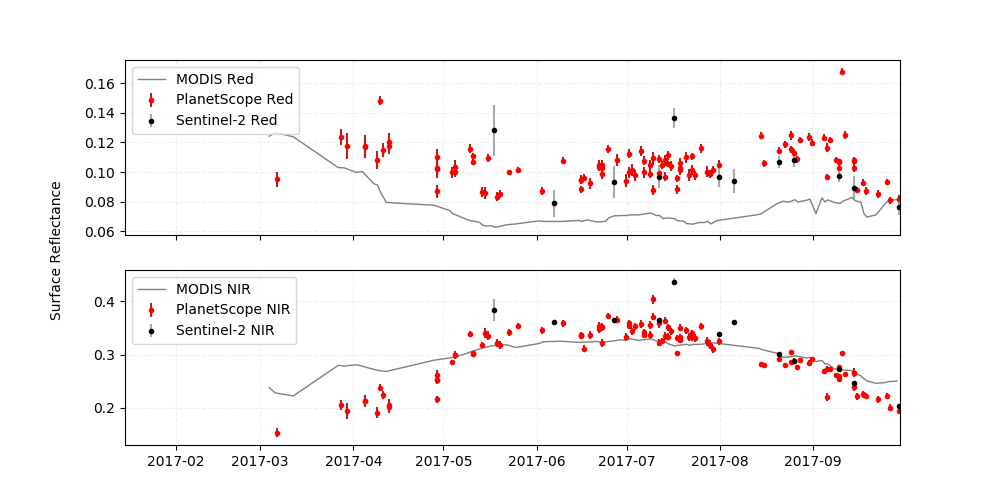

In [123]:
fig, ax = plt.subplots(figsize=(10,5), sharex=True)

ax = plt.subplot(2,1,1)

ax.errorbar(planet_df.index, planet_df['red'], 
             yerr=planet_df['r_std'], fmt='o', ecolor='firebrick', capthick=0.5, ms=3,
             label='PlanetScope Red', color='red')

ax.errorbar(sentinel_df.index, sentinel_df['red'], 
             yerr=sentinel_df['r_std'], fmt='o', ecolor='darkgray', capthick=0.5, ms=3,
             label='Sentinel-2 Red', color='black')

ax.plot_date(CORR.index, CORR['FINAL_red'], '-', color='gray', linewidth=1, label="MODIS Red")

ax.legend(loc = 'upper left')
ax.set_xlim([date(2017, 1, 15), date(2017, 9, 30)])

labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)
plt.grid(ls = '--', alpha=.2)

ax = plt.subplot(2,1,2)

ax.errorbar(planet_df.index, planet_df['nir'], 
             yerr=planet_df['n_std'], fmt='o', ecolor='firebrick', capthick=0.5, ms=3,
             label='PlanetScope NIR', color='red')

ax.errorbar(sentinel_df.index, sentinel_df['nir'], 
             yerr=sentinel_df['n_std'], fmt='o', ecolor='darkgray', capthick=0.5, ms=3,
             label='Sentinel-2 NIR', color='black')

ax.plot_date(CORR.index, CORR['FINAL_nir'], '-', color='gray', linewidth=1, label="MODIS NIR")

ax.set_xlim([date(2017, 1, 15), date(2017, 9, 30)])
ax.legend(loc = 'upper left')
plt.grid(ls = '--', alpha=.2)

fig.text(0.05, 0.5, 'Surface Reflectance', va='center', rotation='vertical')


plt.show()

<IPython.core.display.Javascript object>


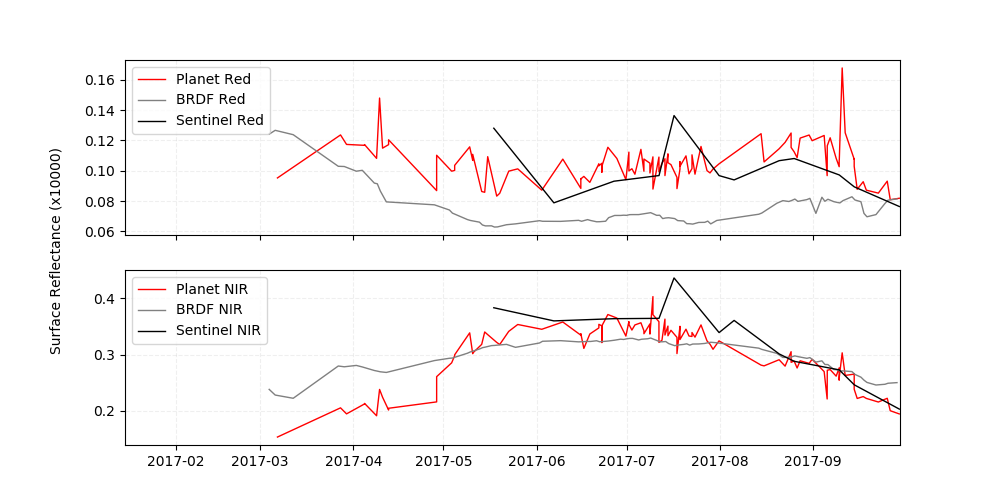

In [109]:
fig, ax = plt.subplots(figsize=(10,5), sharex=True)

ax = plt.subplot(2,1,1)

ax.plot_date(planet_df.index, planet_df['red'], '-', color='red', linewidth=1, label="Planet Red")
ax.plot_date(CORR.index, CORR['FINAL_red'], '-', color='gray', linewidth=1, label="BRDF Red")
ax.plot_date(sentinel_df.index, sentinel_df['red'], '-', color='black', linewidth=1, label="Sentinel Red")
ax.legend(loc = 'upper left')
ax.set_xlim([date(2017, 1, 15), date(2017, 9, 30)])

labels = [item.get_text() for item in ax.get_xticklabels()]

empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)

plt.grid(ls = '--', alpha=.2)

ax = plt.subplot(2,1,2)

ax.plot_date(planet_df.index, planet_df['nir'], '-', color='red', linewidth=1, label="Planet NIR")
ax.plot_date(CORR.index, CORR['FINAL_nir'], '-', color='gray', linewidth=1, label="BRDF NIR")
ax.plot_date(sentinel_df.index, sentinel_df['nir'], '-', color='black', linewidth=1, label="Sentinel NIR")
ax.set_xlim([date(2017, 1, 15), date(2017, 9, 30)])
ax.legend(loc = 'upper left')
plt.grid(ls = '--', alpha=.2)

fig.text(0.05, 0.5, 'Surface Reflectance (x10000)', va='center', rotation='vertical')


plt.show()

In [ ]:
plt.imshow(p_red[11,:,:], extent=[LHS, RHS, BHS, THS])
plt.scatter(pixel_lon, pixel_lat, color='pink')
plt.show()

In [ ]:
CORR['sum'] = 1
sentinel_df['sum'] = 1.2
planet_df['sum'] = 1.1

print len(CORR.index)
print len(planet_df.index)


In [ ]:
fig = plt.subplots(figsize=(10,3), sharex=True)

# ax.plot_date(planet_df.index, planet_df['sum'], '-', color='red', linewidth=1, label="planet red")

# ax.plot_date(CORR.index, CORR['sum'], '-', color='Black', linewidth=2)

plt.scatter(sentinel_df.index, sentinel_df['sum'], color='Black', label="Sentinel-2", s=6)
plt.scatter(planet_df.index, planet_df['sum'], color='red', label="PlanetScope", s=6)
plt.scatter(CORR.index, CORR['sum'], color='gray', label="MODIS BRDF (MCD43A1)", s=6)

frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

# fig.autofmt_xdate()
# ax.set_xlim([date(2017, 3, 1), date(2017, 9, 30)])
# ax.set_ylim([0, 5000])

plt.legend()
plt.show()